In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Parameters

In [2]:
num_classes = 10
min_width = 224
min_height = 224
batch_size= 16

data preparations

In [3]:
from pathlib import Path
import pandas as pd

training_data = Path('../input/10-monkey-species/training/training/') 
validation_data = Path('../input/10-monkey-species/validation/validation/') 
labels_path = Path('../input/10-monkey-species/monkey_labels.txt')


labels_info = []

# Read and cleanup the file
lines = labels_path.read_text().strip().splitlines()
for line in lines[1:]:
    line = line.split(',')
    line = [x.strip(' \n\t\r') for x in line]
    line[3], line[4] = int(line[3]), int(line[4])
    line = tuple(line)
    labels_info.append(line)
    
# Convert the data into a pandas dataframe
labels_info = pd.DataFrame(labels_info, columns=['Label', 'Latin Name', 'Common Name', 
                                                 'Train Images', 'Validation Images'], index=None)
# Show Labels
labels_info.head(10)

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [4]:
# map labels to common names
names_dict = dict(zip(labels_info.index, labels_info["Common Name"]))
print(names_dict)

{0: 'mantled_howler', 1: 'patas_monkey', 2: 'bald_uakari', 3: 'japanese_macaque', 4: 'pygmy_marmoset', 5: 'white_headed_capuchin', 6: 'silvery_marmoset', 7: 'common_squirrel_monkey', 8: 'black_headed_night_monkey', 9: 'nilgiri_langur'}


In [11]:
data_generator_with_aug = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                       horizontal_flip=True,
                                                                       width_shift_range=0.2,
                                                                       height_shift_range=0.2,
                                                                       rotation_range=30)

data_generator_no_aug = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = data_generator_with_aug.flow_from_directory('../input/10-monkey-species/training/training',
                                                              target_size=(min_width, min_height),
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              class_mode='categorical')
validation_generator = data_generator_no_aug.flow_from_directory('../input/10-monkey-species/validation/validation',
                                                                 target_size=(min_width, min_height),
                                                                 batch_size=1,
                                                                 shuffle=False,
                                                                 class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


training a model from scratch
- is super slow (most likely reading and transforming the images is a big bottleneck)

In [6]:
"""
model_from_scratch = keras.Sequential(
    [
        keras.Input(shape=(min_width, min_height, 3)),
        keras.layers.Conv2D(32,kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Conv2D(64,kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ]
)

model_from_scratch.compile(optimizer='rmsprop',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

model_from_scratch.summary()

history = model_from_scratch.fit_generator(train_generator,
                                           epochs=10,
                                           steps_per_epoch=train_generator.samples//batch_size,
                                           validation_data=validation_generator,
                                           validation_steps=validation_generator.samples//batch_size)
"""

"\nmodel_from_scratch = keras.Sequential(\n    [\n        keras.Input(shape=(min_width, min_height, 3)),\n        keras.layers.Conv2D(32,kernel_size=(3, 3), activation='relu'),\n        keras.layers.MaxPooling2D(pool_size=(2,2)),\n        keras.layers.Conv2D(64,kernel_size=(3, 3), activation='relu'),\n        keras.layers.MaxPooling2D(pool_size=(2,2)),\n        keras.layers.Flatten(),\n        keras.layers.Dense(128, activation='relu'),\n        keras.layers.Dropout(0.5),\n        keras.layers.Dense(num_classes, activation='softmax')\n    ]\n)\n\nmodel_from_scratch.compile(optimizer='rmsprop',\n                           loss='categorical_crossentropy',\n                           metrics=['accuracy'])\n\nmodel_from_scratch.summary()\n\nhistory = model_from_scratch.fit_generator(train_generator,\n                                           epochs=10,\n                                           steps_per_epoch=train_generator.samples//batch_size,\n                                        

training a model based on xception

In [7]:
model_xception = keras.Sequential(
    [
        keras.Input(shape=(min_width, min_height, 3)),
        keras.applications.Xception(weights="imagenet", include_top=False),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        #keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ]
)

model_xception.compile(optimizer='rmsprop',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

model_xception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             multiple                  20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 72,247,346
Trainable params: 72,192,818
Non-trainable params: 54,528
_________________________________________________________________


In [8]:
history = model_xception.fit_generator(train_generator,
                                       epochs=26,
                                       steps_per_epoch=train_generator.samples//batch_size,
                                       validation_data=validation_generator,
                                       validation_steps=validation_generator.samples)

model_xception.save('model/xception')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/26
68/68 [==============================] - 29s 433ms/step - loss: 4.0348 - accuracy: 0.1176 - val_loss: 2.6347 - val_accuracy: 0.1618

<AxesSubplot:title={'center':'loss of the model'}, xlabel='epochs', ylabel='loss'>

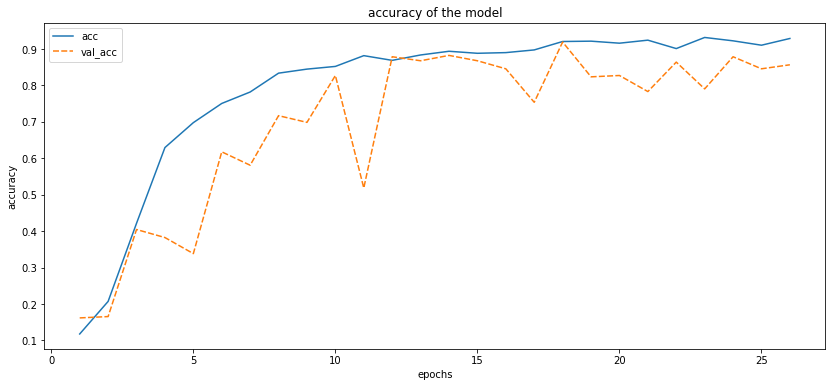

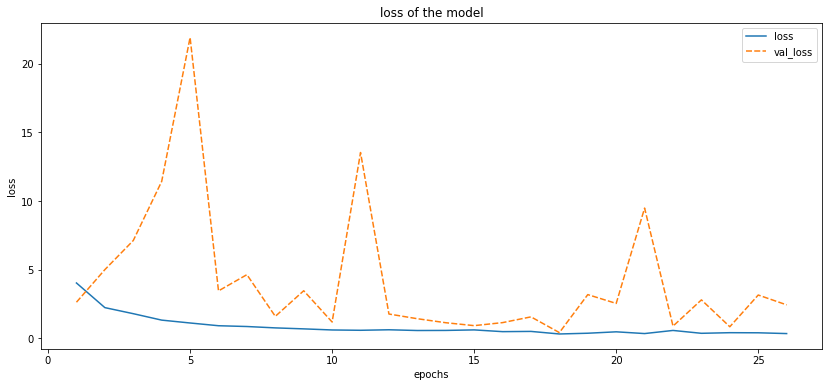

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame

acc = history.history['accuracy']
df_acc = DataFrame (acc, columns=['acc'])
df_acc['val_acc'] = history.history['val_accuracy']
df_acc.index += 1

loss = history.history['loss']
df_loss = DataFrame (loss, columns=['loss'])
df_loss['val_loss'] = history.history['val_loss']
df_loss.index += 1

plt.figure(figsize=(14,6))
plt.title("accuracy of the model")
plt.xlabel("epochs")
plt.ylabel("accuracy")
sns.lineplot(data=df_acc)

plt.figure(figsize=(14,6))
plt.title("loss of the model")
plt.xlabel("epochs")
plt.ylabel("loss")
sns.lineplot(data=df_loss)


<AxesSubplot:>

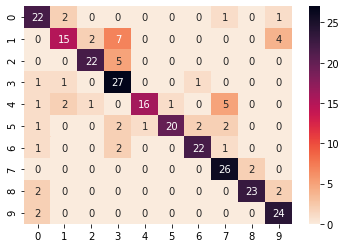

In [14]:
from sklearn.metrics import  confusion_matrix

# Predict the values from the validation dataset and convert them to one hot encoded vectors
y_pred = np.argmax(model_xception.predict_generator(validation_generator, validation_generator.samples), axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = validation_generator.classes, y_pred = y_pred)
# plot the confusion matrix
sns.heatmap(data=confusion_mtx, annot=True, cmap='rocket_r')